# seq2seq with attention for E2E dataset
目的：E2E dtaset を対象としたレビュー文生成

下記のコードの元ネタ：  
https://torch.classcat.com/2021/04/23/pytorch-1-8-tutorials-intermediate-seq2seq-translation/

上記サイトは下記チュートリアルの翻訳：  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

E2E dataset は，下記のサイトに置かれている e2e_refined_dataset_v1_0_0.zip を使用した。

https://github.com/KSKTYM/E2E-refined-dataset/tree/main/release

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# 単語の one-hot encoding へ向けた準備
SOS_token = 0
EOS_token = 1

class MR:
    # def __init__(self, name):
    def __init__(self):
        #self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
        # (メモ) MR には SOS / EOS は不要
        # self.index2word = {0: "SOS", 1: "EOS"}
        # self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# フランス語／英語それぞれにコードブックが必要なため Lang クラスを準備する
class Lang:
    # def __init__(self, name):
    def __init__(self):
        # self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# (注) 以下は単語数を減らすための工夫であり，本質的でない。

# Unicode 文字を ASCII に変え、総てを小文字にして、そして殆どの句読点をトリム
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    # s = unicodeToAscii(s.lower().strip())
    s = unicodeToAscii(s.strip()) # 小文字化しない for E2E dataset
    s = re.sub(r"([,.!?])", r" \1", s) # カンマ，ピリオド，!, ? の前にスペースを入れる
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # カンマを消さないよう，この処理は不要
    return s

In [4]:
import json

def load_e2e_data(path):
    mrs = list()
    texts = list()
    
    with open(path, "r") as f:
        js = json.load(f)

        for item in js:
            order = item['mr']['order'] # mr に含まれる属性の順番
            value = item['mr']['value'] # 各属性に対応する値

            # order から順番に応じて属性(attribute / slot) を並べる
            sorted_order = sorted(order.items(), key=lambda x:x[1])
            new_order = [k for k, v in sorted_order if v != 0]

            # seq2seq へ与える形式で mr を構成する
            mr = []
            for attr in new_order:
                mr.append('inform')
                mr.append(attr)
                mr.append(value[attr])

            # seq2seq へ与える形式で text を構成する
            mrs.append(mr)
            texts.append(item['txt'])
            
    return mrs, texts

train_file = "e2e_refined_dataset/e2e_train.json"
mrs, texts = load_e2e_data(train_file)

In [5]:
# データ読み込みの準備
# def readLangs(lang1, lang2, reverse=False):
def readLangs():
    print("Reading lines...")

    # Read the file and split into lines
    train_file = "e2e_refined_dataset/e2e_train.json"
    mrs, texts = load_e2e_data(train_file)

    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')

    # Split every line into pairs and normalize
    # pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = []
    for mr, text in zip(mrs, texts):
        splitted_text = normalizeString(text)
        # print(splitted_text)
        pairs.append([mr, splitted_text])

    # Reverse pairs, make Lang instances
    '''
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    '''
    input_mr = MR()
    output_text = Lang()

    return input_mr, output_text, pairs

input_mr, output_text, pairs = readLangs()
print(pairs[:3])

Reading lines...
[[['inform', 'name', 'THE VAULTS', 'inform', 'eatType', 'pub', 'inform', 'near', 'CAFÉ ADRIATIC', 'inform', 'customer rating', '5 out of 5', 'inform', 'priceRange', 'more than £30'], 'THE VAULTS pub near CAFE ADRIATIC has a 5 star rating . Prices start at £30 .'], [['inform', 'near', 'CAFÉ BRAZIL', 'inform', 'name', 'THE CAMBRIDGE BLUE', 'inform', 'eatType', 'pub', 'inform', 'priceRange', '£20-25'], 'Close to CAFE BRAZIL , THE CAMBRIDGE BLUE pub serves delicious tuscan beef for the cheap price of £20 . Delicious pub food .'], [['inform', 'name', 'THE EAGLE', 'inform', 'customer rating', 'low', 'inform', 'eatType', 'coffee shop', 'inform', 'near', 'BURGER KING', 'inform', 'area', 'riverside', 'inform', 'familyFriendly', 'yes', 'inform', 'priceRange', 'less than £20', 'inform', 'food', 'Japanese'], 'THE EAGLE is a low rated coffee shop near BURGER KING and the riverside that is family friendly and is less than £20 for Japanese food .']]


In [6]:
# MAX_LENGTH = 10
MR_MAX_LENGTH = 25 # 10
TEXT_MAX_LENGTH = 100

In [7]:
# (=====注意=====) E2E では使わない !!

# (注) 単語数チェックは必要だが，トリミングは本質的でない。

# データセットを比較的短くて単純なセンテンスだけにトリム
# MAX_LENGTH = 100 # 10

'''
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
'''

'\neng_prefixes = (\n    "i am ", "i m ",\n    "he is", "he s ",\n    "she is", "she s ",\n    "you are", "you re ",\n    "we are", "we re ",\n    "they are", "they re "\n)\n\ndef filterPair(p):\n    return len(p[0].split(\' \')) < MAX_LENGTH and         len(p[1].split(\' \')) < MAX_LENGTH and         p[1].startswith(eng_prefixes)\n\ndef filterPairs(pairs):\n    return [pair for pair in pairs if filterPair(pair)]\n'

In [8]:
# def prepareData(lang1, lang2, reverse=False):
def prepareData():
    # データ読み込み
    # input_lang / output_lang には「単語とIDのコードブック」が格納される
    # pairs には「フランス語文と英語文のペア」が格納される
    # input_mr, output_text, pairs = readLangs(lang1, lang2, reverse)
    input_mr, output_text, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    
    # 単語数が MAX_LENGTH を超える文の除去 & eng_prefixes で定義された文型のみに絞り込む
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))

    # 全データについて，単語と ID を紐付ける
    print("Counting words...")
    for pair in pairs:
        # input_lang.addSentence(pair[0])
        # output_lang.addSentence(pair[1])
        input_mr.addSentence(pair[0])
        output_text.addSentence(pair[1])
        
    # (参考) 単語数のカウント
    print("Counted words:")
    # print(input_lang.name, input_lang.n_words)
    # print(output_lang.name, output_lang.n_words)
    # return input_lang, output_lang, pairs
    print("MR:", input_mr.n_words)
    print("Text:", output_text.n_words)
    return input_mr, output_text, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
input_mr, output_text, pairs = prepareData()
print(random.choice(pairs))

Reading lines...
Read 40560 sentence pairs
Counting words...
Counted words:
MR: 95
Text: 3083
[['inform', 'name', 'ALIMENTUM', 'inform', 'food', 'French', 'inform', 'familyFriendly', 'no', 'inform', 'priceRange', 'more than £30', 'inform', 'area', 'riverside'], 'ALIMENTUM offers French food . It is not child-friendly . The prices are more than £30 . Located in the area of riverside .']


In [9]:
# (参考)
print(input_mr.word2index['eatType'])
print(output_text.word2index['prices'])

3
131


---
## seq2seq モデル

エンコーダが生成する(単一の)ベクトル = 理想的には、入力センテンスの「意味」

In [26]:
# エンコーダ
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2

        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru = nn.RNN(hidden_size, hidden_size, num_layers=self.num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        # output = embedded # (メモ) 余分な記述ゆえ，書き直し
        # output, hidden = self.gru(output, hidden) # (メモ) 余分な記述ゆえ，書き直し
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    # エンコーダへ渡す初期隠れ状態 (zero ベクトル)
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [27]:
# デコーダ
# (注) 使用しない
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    # デコーダへ渡す初期隠れ状態 (zero ベクトル) ・・・(メモ) seq2seq モデルでは不要では？
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [28]:
# attention デコーダ
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        # self.max_length = max_length
        self.mr_max_length = mr_max_length
        self.text_max_length = text_max_length

        self.num_layers = 2
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn = nn.Linear(self.hidden_size * 2, self.mr_max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        # self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.gru = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        print("hidden:", hidden.shape)
        # attention weight の算出
        print("input:", input.shape) # torch.Size([1, 1]
        print("embedded:", embedded.shape) # torch.Size([1, 1, 256]
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        print("attn_weights:", attn_weights.shape) # torch.Size([1, 1, 25] ・・・入力文の単語数に依存
        print("encoder_outputs:", encoder_outputs.shape) # torch.Size([25, 256])
        #print("encoder_outputs.unsqueeze(0):", encoder_outputs.unsqueeze(0).size()) # torch.Size([1, 10, 256])
        
        # エンコーダの出力と attention weight との内積
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        print("attn_applied:", attn_applied.shape) # torch.Size([1, 1, 256])
        
        # アテンションとデコーダへの入力(embedding)を Linear 層へ投げ込む
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        print("output:", output.shape) # torch.Size([1, 512])
        output = self.attn_combine(output).unsqueeze(0)
        print("output:", output.shape) # torch.Size([1, 256])

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        print("output:", output.shape) # torch.Size([1, 256])
        print("hidden:", hidden.shape) # torch.Size([1, 256])

        output = F.log_softmax(self.out(output[0]), dim=1)
        
        import sys
        sys.exit()
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 学習

In [29]:
# MR の属性/値ペア ＆ テキストを数値化 ＆ テンソル化する関数群
'''
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)
'''
def indexesFromMR(input_mr, sentence):
    return [input_mr.word2index[word] for word in sentence]

def indexesFromSentence(output_text, sentence):
    return [output_text.word2index[word] for word in sentence.split(' ')]

def tensorFromMR(input_mr, sentence):
    indexes = indexesFromMR(input_mr, sentence)
    # indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence(output_text, sentence):
    indexes = indexesFromSentence(output_text, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromMR(input_mr, pair[0])
    target_tensor = tensorFromSentence(output_text, pair[1])
    return (input_tensor, target_tensor)

In [30]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
    # エンコーダの初期隠れ層を定義 (zero ベクトル)
    encoder_hidden = encoder.initHidden()

    # optimizer の初期化
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # 入力，出力それぞれに含まれる単語数
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # エンコードの全ての隠れ層の値を保存するための変数
    # 長さが MAX_LENGTH である点に注意
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    encoder_outputs = torch.zeros(mr_max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # エンコード : 埋め込み + GRU
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # 隠れ層の値を溜める
        encoder_outputs[ei] = encoder_output[0, 0]

    # デコーダに与える最初のトークン : SOS_token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # デコーダに与える隠れ層の初期値は，エンコーダの最終隠れ層の値
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # デコード
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # デコードの結果と所望の出力（この例では，期待する英単語）から損失を求める
            loss += criterion(decoder_output, target_tensor[di])
            # デコーダに与える次のトークンを準備
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # 文ペアを１つ，エンコード／デコードし終えたならば逆伝搬
    loss.backward()

    # エンコーダー／デコーダそれぞれの optimizer を更新
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
# helper functions
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [32]:
# 損失の可視化
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [33]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # optimizer の定義
    '''
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    '''
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
    
    # 学習対象とするフランス語文／英語文のペアをランダムな順序，かつ重複ありにて生成
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    # 損失関数の定義
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # 学習対象とするフランス語文／英語文のペアをひとつ選ぶ
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # input tensor を並べ替える (2023.08.14)
        '''
        p = np.random.rand() # [0, 1) random number
        if p < 0.3:
            tmp = input_tensor.reshape((-1,3))
            idx = torch.randperm(input_tensor.shape[0] // 3)
            input_tensor = tmp[idx].reshape((-1,1))
        '''
            

        # 学習
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # ログ出力
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    '''
    # 損失の可視化
    showPlot(plot_losses)
    '''
    
    return plot_losses

In [34]:
# 学習
hidden_size = 256 # GRU の隠れ層のサイズ

# エンコーダ／デコーダの定義
encoder1 = EncoderRNN(input_mr.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_text.n_words, dropout_p=0.1).to(device)

# 学習 (重複ありにて 75000ペアを学習させる)
# (2022.12.05 メモ) 5,000ペアを学習するのに 2m 15s を要する。
# (2022.12.05 メモ) 学習データには 40560件の (mr, text) ペアが存在するから
# 75000ペアの学習では不十分だろう。
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
### plot_losses = trainIters(encoder1, attn_decoder1, 10000, print_every=5000)
plot_losses = trainIters(encoder1, attn_decoder1, 100000, print_every=5000, learning_rate=0.0001)

# 損失の可視化
showPlot(plot_losses)

hidden: torch.Size([2, 1, 256])
input: torch.Size([1, 1])
embedded: torch.Size([1, 1, 256])
attn_weights: torch.Size([1, 25])
encoder_outputs: torch.Size([25, 256])
attn_applied: torch.Size([1, 1, 256])
output: torch.Size([1, 512])
output: torch.Size([1, 1, 256])
output: torch.Size([1, 1, 256])
hidden: torch.Size([2, 1, 256])


SystemExit: 

## 評価

In [ ]:
def evaluate(encoder, decoder, sentence, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = tensorFromMR(input_mr, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        encoder_outputs = torch.zeros(mr_max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # (メモ) 元が zero vector だからよいけど，代入じゃ駄目なの？

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)
        decoder_attentions = torch.zeros(text_max_length, mr_max_length) #### (12/5) 自信なし！

        for di in range(text_max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                # decoded_words.append(output_lang.index2word[topi.item()])
                decoded_words.append(output_text.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
evaluateRandomly(encoder1, attn_decoder1)

## attention の可視化

['THE', 'WATERMAN', 'pub', 'a', 'pub', 'in', 'the', 'riverside', 'area', 'of', '3', 'out', 'of', 'of', '5', '.', '']


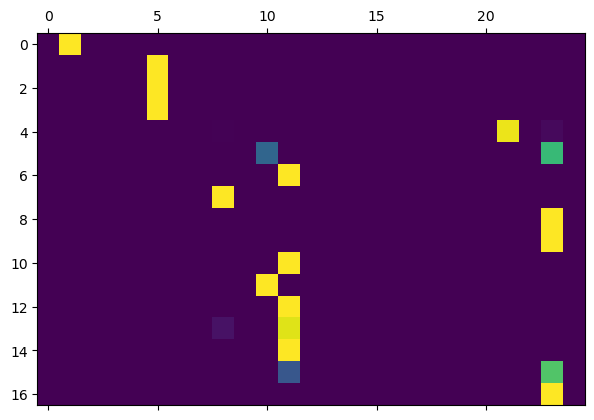

In [30]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1,
    ['inform', 'name', 'THE WATERMAN', 'inform', 'eatType', 'pub', 'inform', 'area', 'riverside', 'inform', 'customer rating', '3 out of 5']
)
print(output_words)
plt.matshow(attentions.numpy())

input = ['inform', 'name', 'THE EAGLE', 'inform', 'food', 'Japanese', 'inform', 'customer rating', 'low']
output = THE EAGLE serves Japanese food and has a low customer rating . 


/tmp/ipykernel_7102/2570250603.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence +
/tmp/ipykernel_7102/2570250603.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


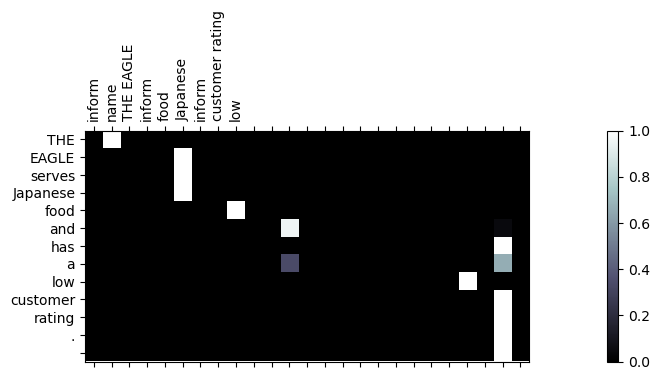

input = ['inform', 'name', 'ZIZZI', 'inform', 'food', 'French', 'inform', 'eatType', 'pub', 'inform', 'customer rating', 'low', 'inform', 'familyFriendly', 'yes']
output = ZIZZI is a French pub a a a low customer family friendly . 


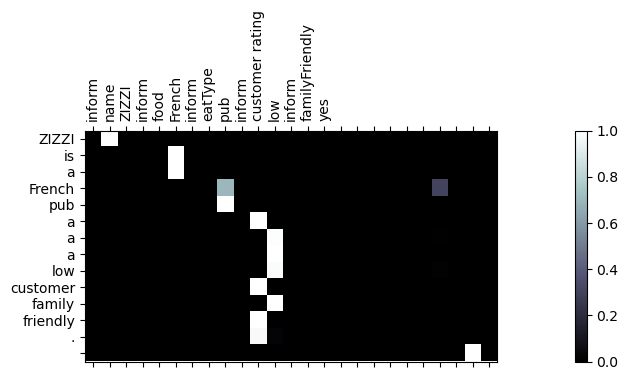

In [32]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    # fig = plt.figure()
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    '''
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [''], rotation=90)
    '''
    ax.set_xticklabels([''] + input_sentence +
                       [''], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

'''
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")
'''

mr1 = ['inform', 'name', 'THE EAGLE', 'inform', 'food', 'Japanese', 'inform', 'customer rating', 'low']
evaluateAndShowAttention(mr1)

mr2 = ['inform', 'name', 'ZIZZI', 'inform', 'food', 'French', 'inform', 'eatType', 'pub', 'inform', 'customer rating', 'low', 'inform', 'familyFriendly', 'yes']
evaluateAndShowAttention(mr2)

---
## BLEU による評価

In [20]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.gleu_score import corpus_gleu

def evaluateWithBLEU(encoder, decoder, n=10):
    list_of_references = []
    hypotheses = []
    
    hist_mr_length = []
    hist_bleus = []
    for i in range(n):
        pair = random.choice(pairs)
        #print('>', pair[0])
        #print('=', pair[1])
        hist_mr_length.append(len(pair[0]) / 3)
        
        reference = pair[1].split(' ')
        list_of_references.append([reference])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        hypothesis = output_words
        hypotheses.append(hypothesis)

        print("reference:", reference)
        print("hypothesis:", hypothesis)
        s = sentence_bleu([reference], hypothesis)
        print(s)
        hist_bleus.append(s) # BLEU のヒストグラムを作るため，保存
        #output_sentence = ' '.join(output_words)
        #print('<', output_sentence)
        #print('')
    #print(list_of_references)
    #print(hypotheses)
    score = corpus_bleu(list_of_references, hypotheses)
    print("BLEU:", score)

    score = corpus_gleu(list_of_references, hypotheses)
    print("GLEU:", score)

    return hist_bleus, hist_mr_length

hist_bleus, hist_mr_length = evaluateWithBLEU(encoder1, attn_decoder1, n=1000)

reference: ['If', 'you', 'are', 'looking', 'for', 'a', 'family', 'friendly', 'pub', ',', 'THE', 'OLIVE', 'GROVE', 'is', 'perfect', 'for', 'you', '.', 'It', 'is', 'a', 'cheap', 'establishment', 'that', 'is', 'located', 'north', 'of', 'the', 'city', 'centre', ',', 'close', 'to', 'the', 'river', '.']
hypothesis: ['The', 'family', 'friendly', 'pub', 'THE', 'OLIVE', 'GROVE', ',', 'cheap', ',', 'cheap', 'price', 'range', '.', 'It', 'is', 'located', 'in', 'the', 'city', 'centre', '.', '']
3.255205027548449e-78
reference: ['A', 'fast', 'food', 'coffee', 'shop', 'is', 'called', 'THE', 'MILL', '.', 'It', 'is', 'in', 'the', 'city', 'centre', 'near', 'THE', 'SORRENTO', 'and', 'has', 'a', 'high', 'price', 'range', '.']
hypothesis: ['There', 'is', 'a', 'fast', 'coffee', 'shop', 'called', 'THE', 'MILL', 'THE', 'MILL', 'THE', 'the', 'city', 'centre', '.', '']
3.0390391656485743e-78
reference: ['COTTO', 'is', 'a', 'low', 'rated', ',', 'child-friendly', ',', 'Japanese', 'restaurant', 'near', 'RANCH', '.

/home/muto/anaconda3/envs/py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


reference: ['When', 'looking', 'for', 'a', 'pub', 'near', 'CAFE', 'ROUGE', ',', 'THE', 'PLOUGH', 'is', 'high', 'end', 'and', 'is', 'child', 'friendly', '.']
hypothesis: ['There', 'pub', 'near', 'CAFE', 'ROUGE', 'is', 'THE', 'PLOUGH', 'PLOUGH', 'is', 'family', 'friendly', '.', '']
0.1860067949655926
reference: ['STRADA', 'is', 'a', 'Chinese', 'food', 'restaurant', 'where', 'prices', 'range', 'more', 'than', '£30', '.', 'STRADA', 'is', 'not', 'children', 'friendly', ',', 'but', 'they', 'have', 'a', 'high', 'customer', 'rating', '.', 'You', 'can', 'find', 'STRADA', 'near', 'RAINBOW', 'VEGETARIAN', 'CAFE', '.']
hypothesis: ['STRADA', 'is', 'a', 'Chinese', 'restaurant', 'with', 'a', 'price', 'range', 'of', 'more', 'than', '£30', '.', 'It', 'is', 'not', 'friendly', 'and', 'has', 'a', 'customer', 'rating', '.', '']
0.17159627021140186
reference: ['Located', 'in', 'the', 'city', 'centre', 'is', 'THE', 'RICE', 'BOAT', ',', 'a', 'family-friendly', 'restaurant', 'serving', 'fast', 'food', '.', 'C

/home/muto/anaconda3/envs/py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


reference: ['There', 'is', 'a', 'kid', 'friendly', 'restaurant', 'with', 'moderate', 'prices', 'named', 'TRAVELLERS', 'REST', 'BEEFEATER', '.']
hypothesis: ['A', 'family', 'friendly', 'restaurant', 'with', 'a', 'price', 'price', 'range', 'price', 'range', '.', 'TRAVELLERS', 'REST', 'BEEFEATER', '.', '']
0.2140909265975804
reference: ['THE', 'GOLDEN', 'PALACE', 'is', 'a', '3', 'star', 'rated', 'coffee', 'shop', 'situated', 'next', 'to', 'the', 'river', 'just', 'on', 'the', 'edge', 'of', 'the', 'city', 'centre', '.']
hypothesis: ['THE', 'GOLDEN', 'PALACE', 'is', 'a', '3', 'star', 'coffee', 'shop', 'coffee', 'shop', 'in', 'the', 'city', 'centre', '.', '']
0.35194812825692934
reference: ['LOCH', 'FYNE', 'is', 'a', 'restaurant', 'providing', 'Chinese', 'food', 'in', 'the', '£20-25', 'price', 'range', '.']
hypothesis: ['LOCH', 'FYNE', 'is', 'a', 'restaurant', 'that', 'serves', 'food', 'food', 'food', 'at', '£20-25', '.', '']
0.29899503549981366
reference: ['THE', 'RICE', 'BOAT', 'provides', 

reference: ['Near', 'BURGER', 'KING', ',', "you'll", 'find', 'THE', 'EAGLE', ',', 'a', 'family', 'coffee', 'shop', 'that', 'sells', 'sushi', '.', 'It', 'is', 'moderately', 'expensive', 'and', 'has', 'poor', 'ratings', '.']
hypothesis: ['Near', 'BURGER', 'KING', 'THE', 'EAGLE', 'is', 'THE', 'EAGLE', ',', 'is', 'a', 'coffee', 'shop', 'shop', 'that', 'Japanese', 'food', 'food', 'food', 'price', 'range', '.', 'a', 'customer', 'rating', '.', '']
3.7501442843110273e-78
reference: ['There', 'is', 'a', 'French', 'coffee', 'shop', 'called', 'THE', 'GOLDEN', 'PALACE', '.', 'It', 'is', 'located', 'in', 'the', 'riverside', 'area', ',', 'has', 'a', 'high', 'price', 'range', 'and', 'a', 'customer', 'rating', 'of', '3', 'out', 'of', '5', '.']
hypothesis: ['There', 'is', 'a', 'French', 'coffee', 'shop', 'called', 'THE', 'GOLDEN', 'PALACE', 'in', 'the', 'riverside', 'area', '.', 'It', 'has', 'a', 'high', 'price', 'range', 'and', 'a', 'customer', 'rating', 'of', '3', 'out', 'of', '5', '.', '']
0.7677497

reference: ['Looking', 'to', 'eat', 'Japanese', 'for', 'under', '£20', ',', 'try', 'THE', 'WRESTLERS', '.', 'No', 'children', 'and', 'an', 'average', 'rating', '.']
hypothesis: ['There', 'Japanese', 'food', 'for', 'less', 'than', '£20', ',', 'THE', 'WRESTLERS', 'THE', 'WRESTLERS', 'is', 'not', 'not', 'not', 'family', 'friendly', 'and', 'has', 'an', 'average', 'customer', 'rating', '.', '']
7.608640167544372e-155
reference: ['THE', 'PHOENIX', 'in', 'the', 'city', 'centre', 'serves', 'French', 'food', 'with', 'low', 'customer', 'ratings', '.']
hypothesis: ['THE', 'PHOENIX', 'is', 'located', 'in', 'the', 'city', 'centre', ',', 'serves', 'French', 'food', '.', 'It', 'has', 'a', 'low', 'customer', 'rating', '.', '']
0.2046592065585361
reference: ['COTTO', 'is', 'a', '3', 'stars', 'coffee', 'shop', 'where', 'there', 'are', 'low-priced', 'food', '.', 'It', 'is', 'in', 'THE', 'PORTLAND', 'ARMS', 'located', 'in', 'the', 'city', 'centre', '.']
hypothesis: ['COTTO', 'is', 'a', '3', 'star', 'coffe

reference: ['The', 'MIDSUMMER', 'HOUSE', 'has', 'a', 'low', 'customer', 'rating', 'that', 'serves', 'fast-food', 'and', 'is', 'located', 'near', 'CAFE', 'ROUGE', '.']
hypothesis: ['MIDSUMMER', 'HOUSE', 'is', 'a', 'low', 'rated', 'fast', 'food', '.', 'It', 'is', 'located', 'near', 'ROUGE', 'ROUGE', '.', '']
3.731878203187928e-78
reference: ['THE', 'DUMPLING', 'TREE', ',', 'near', 'THE', 'PORTLAND', 'ARMS', ',', 'is', 'a', 'family-friendly', 'pub', 'that', 'serves', 'Indian', 'food', '.']
hypothesis: ['THE', 'DUMPLING', 'TREE', ',', 'near', 'THE', 'PORTLAND', 'ARMS', ',', 'is', 'a', 'family', 'friendly', 'pub', 'pub', 'that', 'serves', 'Indian', 'food', '.', '']
0.7098232254187811
reference: ['THE', 'RICE', 'BOAT', 'at', 'the', 'riverside', 'is', 'kids-friendly', 'fast', 'food', 'restaurant', 'rated', '1', 'out', 'of', '5', '.']
hypothesis: ['THE', 'RICE', 'BOAT', 'is', 'located', 'riverside', 'riverside', 'area', 'is', 'friendly', 'friendly', 'fast', 'food', 'restaurant', 'with', 'a', '

reference: ['BROWNS', 'CAMBRIDGE', 'is', 'a', 'family', 'friendly', 'coffee', 'shop', 'that', 'is', 'rated', 'average', 'and', 'is', 'near', 'CROWNE', 'PLAZA', 'HOTEL', '.']
hypothesis: ['BROWNS', 'CAMBRIDGE', 'is', 'a', 'family', 'friendly', 'coffee', 'shop', 'with', 'an', 'average', 'customer', 'rating', 'rating', '.', 'It', 'is', 'near', 'CROWNE', 'PLAZA', 'HOTEL', '.', '']
0.5102002548573253
reference: ['THE', 'RICE', 'BOAT', 'is', 'the', 'place', 'to', 'be', 'if', 'your', 'wanting', 'fast', 'food', 'by', 'the', 'riverside', '.']
hypothesis: ['THE', 'RICE', 'BOAT', 'is', 'a', 'fast', 'food', 'place', 'in', 'the', 'riverside', 'area', '.', '']
0.20501024608209106
reference: ['An', 'Indian', 'restaurant', 'called', 'THE', 'GOLDEN', 'CURRY', 'is', 'located', 'near', 'THE', 'BAKERS', 'that', 'offers', 'cheap', 'prices', 'and', 'a', 'family', 'friendly', 'experience', '.']
hypothesis: ['There', 'is', 'an', 'Indian', 'restaurant', 'THE', 'GOLDEN', 'CURRY', 'near', 'THE', 'BAKERS', '.', '

reference: ['COTTO', 'is', 'an', 'Indian', 'coffee', 'shop', 'in', 'the', 'high', 'price', 'range', 'near', 'THE', 'PORTLAND', 'ARMS', 'at', 'the', 'riverside', '.', 'It', 'has', 'an', 'average', 'customer', 'rating', '.']
hypothesis: ['COTTO', 'is', 'an', 'Indian', 'coffee', 'shop', 'with', 'high', 'high', 'price', 'range', '.', 'It', 'is', 'located', 'near', 'THE', 'PORTLAND', 'ARMS', '.', '']
0.33919182578128976
reference: ['THE', 'PLOUGH', 'is', 'a', 'family', 'friendly', 'pub', 'near', 'CAFE', 'ROUGE', '.', 'The', 'food', 'is', 'cheap', '.']
hypothesis: ['THE', 'PLOUGH', 'is', 'a', 'family', 'friendly', 'pub', 'near', 'CAFE', 'ROUGE', '.', 'It', 'is', 'cheap', 'and', 'is', 'cheap', '.', '']
0.6165255292124369
reference: ['For', 'exquisite', 'fast', 'food', 'visit', 'THE', 'GOLDEN', 'CURRY', 'a', 'child', 'friendly', 'restaurant', 'near', 'THE', 'BAKERS', '.']
hypothesis: ['There', 'is', 'a', 'fast', 'food', 'THE', 'GOLDEN', 'CURRY', 'is', 'friendly', 'friendly', 'friendly', 'resta

reference: ['There', 'is', 'a', 'moderate', 'priced', 'pub', 'that', 'serves', 'Indian', 'food', ',', 'called', 'WILDWOOD', ',', 'with', 'a', 'low', 'customer', 'rating', 'of', '1', 'out', 'of', '5', '.']
hypothesis: ['There', 'is', 'a', 'pub', 'pub', 'that', 'serves', 'food', 'food', 'food', 'food', 'WILDWOOD', '.', 'It', 'has', 'a', 'customer', 'rating', 'of', '1', 'out', 'of', '5', '.', '']
0.39618675974573386
reference: ['For', 'an', 'English', 'meal', 'in', 'a', 'family', 'friendly', 'restaurant', ',', 'the', 'LOCH', 'FYNE', 'offers', 'meals', 'for', 'less', 'than', '20', '.']
hypothesis: ['English', 'is', 'a', 'family', 'friendly', 'restaurant', 'restaurant', 'LOCH', 'FYNE', 'FYNE', '.', 'The', 'price', 'range', 'is', 'less', 'than', '£20', '.', '']
0.1712473044894657
reference: ['For', 'average', 'fast', 'food', 'in', 'riverside', 'near', 'CAFE', 'ROUGE', ',', 'visit', 'THE', 'GOLDEN', 'CURRY', '.', 'Yes', ',', 'it', 'is', 'children', 'friendly', '.']
hypothesis: ['There', 'food

reference: ['A', 'child', 'friendly', 'restaurant', 'with', 'high', 'prices', 'is', 'TRAVELLERS', 'REST', 'BEEFEATER', '.']
hypothesis: ['A', 'family', 'friendly', 'restaurant', 'with', 'a', 'high', 'price', 'range', 'price', 'range', '.', '.', '.', '']
3.144783539361942e-78
reference: ['BIBIMBAP', 'HOUSE', 'is', 'a', 'high', 'price', 'fast', 'food', 'restaurant', 'near', 'CLARE', 'HALL', 'in', 'the', 'city', 'centre', '.']
hypothesis: ['BIBIMBAP', 'HOUSE', 'is', 'a', 'high', 'priced', 'fast', 'food', 'restaurant', 'near', 'CLARE', 'HALL', 'in', 'the', 'city', 'centre', '.', '']
0.7778111223054219
reference: ['THE', 'GOLDEN', 'CURRY', 'is', 'a', 'highly', 'rated', 'child', 'friendly', 'Japanese', 'restaurant', '.']
hypothesis: ['THE', 'GOLDEN', 'CURRY', 'is', 'a', 'highly', 'rated', ',', 'family', 'friendly', 'Japanese', 'restaurant', '.', '']
0.6162607099729586
reference: ['There', 'is', 'a', 'children', 'friendly', 'Japanese', 'coffee', 'shop', 'called', 'THE', 'WRESTLERS', 'which', 

reference: ['The', 'STRADA', 'sells', 'Chinese', 'food', 'at', 'moderate', 'prices', '.', 'I', 'give', 'it', '3', 'out', 'of', '5', 'stars', 'and', 'this', 'place', 'is', 'kids', 'friendly', '.', 'It', 'is', 'next', 'to', 'RAINBOW', 'VEGETARIAN', 'CAFE', '.']
hypothesis: ['STRADA', 'is', 'a', 'Chinese', 'food', 'in', 'the', 'moderate', 'price', 'range', '.', 'a', '3', 'out', 'of', '5', '.', '.', '.', 'is', 'family', 'friendly', '.', 'near', 'RAINBOW', 'VEGETARIAN', 'CAFE', '.', '']
0.18847637621732105
reference: ['THE', 'WATERMAN', 'is', 'a', 'highly', 'rated', ',', 'child', 'friendly', 'English', 'eating', 'establishment', 'near', 'the', 'city', 'centre', '.', 'The', 'price', 'range', 'is', 'more', 'than', '£30', '.']
hypothesis: ['THE', 'WATERMAN', 'is', 'a', 'highly', 'rated', 'family', 'friendly', 'friendly', 'English', 'food', 'food', 'food', 'It', 'is', 'in', 'the', 'city', 'centre', '.', '.', 'price', 'range', 'more', 'than', '£30', '.', '']
0.3765567596426258
reference: ['Low',

reference: ['AROMI', 'is', 'a', 'French', 'family-friendly', 'coffee', 'shop', 'in', 'the', 'city', 'centre', 'that', 'has', 'an', 'average', 'customer', 'rating', '.']
hypothesis: ['AROMI', 'is', 'a', 'French', 'food', 'family', 'friendly', 'coffee', 'shop', 'in', 'the', 'city', 'centre', '.', 'It', 'has', 'an', 'average', 'customer', 'rating', '.', '']
0.5366411241731205
reference: ['THE', 'MILL', 'is', 'a', 'British', 'pub', 'with', 'cheap', 'prices', '.']
hypothesis: ['THE', 'MILL', 'is', 'an', 'English', 'pub', 'with', 'cheap', 'prices', '.', '']
0.46924700641056
reference: ['MIDSUMMER', 'HOUSE', 'is', 'located', 'near', 'ALL', 'BAR', 'ONE', '.', 'It', 'is', 'a', 'cheap', 'Indian', 'restaurant', 'with', '5', 'out', 'of', '5', 'rating', '.']
hypothesis: ['MIDSUMMER', 'HOUSE', 'is', 'located', 'near', 'ALL', 'BAR', 'ONE', 'ONE', '.', 'It', 'serves', 'Indian', 'Indian', 'restaurant', 'with', 'a', 'customer', 'rating', 'of', '5', 'out', 'of', '5', '.', '']
0.46517269234910513
referenc

reference: ['A', 'riverside', ',', 'kid', 'friendly', 'pub', ',', 'AROMI', ',', 'has', 'an', 'average', 'customer', 'rating', '.']
hypothesis: ['In', 'the', 'riverside', 'area', 'there', 'is', 'a', 'pub', 'friendly', 'pub', 'called', '.', '.', 'It', 'has', 'an', 'average', 'customer', 'rating', '.', '']
0.2591641360720012
reference: ['There', 'is', 'an', 'average', 'price', 'family', 'friendly', 'coffee', 'shop', 'THE', 'CRICKETERS', '.', 'It', 'is', 'located', 'near', 'THE', 'PORTLAND', 'ARMS', '.']
hypothesis: ['There', 'is', 'a', 'moderate', 'price', 'family', 'friendly', 'coffee', 'shop', 'THE', 'CRICKETERS', 'THE', 'THE', 'THE', 'PORTLAND', 'ARMS', '.', '']
0.4464416860937431
reference: ['CAFE', 'ROUGE', 'is', 'a', 'restaurant', 'providing', 'Italian', 'food', '.', 'It', 'is', 'located', 'at', 'COTTO', '.']
hypothesis: ['CAFE', 'ROUGE', 'is', 'a', 'restaurant', 'that', 'serves', 'food', 'food', 'food', 'near', 'near', '.', 'COTTO', '.', '']
0.2803950119994003
reference: ['THE', 'W

/home/muto/anaconda3/envs/py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


reference: ['There', 'is', 'a', 'cheap', 'average', 'rated', 'pub', 'near', 'CAFE', 'ADRIATIC', 'called', 'THE', 'VAULTS', '.']
hypothesis: ['There', 'is', 'a', 'cheap', ',', 'with', 'an', 'average', 'customer', 'rating', 'is', 'located', 'near', 'CAFE', 'ADRIATIC', '.', 'THE', 'VAULTS', '.', '']
0.22686182598679874
reference: ['STRADA', 'for', 'Italian', 'food', 'with', 'more', 'than', '£30', 'for', 'children', 'friendly', 'near', 'RAINBOW', 'VEGETARIAN', 'CAFE', '.']
hypothesis: ['STRADA', 'is', 'an', 'Italian', 'food', 'with', 'a', 'price', 'range', 'of', 'more', 'than', '.', '.', 'is', 'friendly', '.', 'near', 'RAINBOW', 'VEGETARIAN', 'CAFE', '.', '']
0.23713320246552005
reference: ['There', 'is', 'a', 'family', 'friendly', 'restaurant', 'that', 'is', 'high', 'priced', 'called', 'GREEN', 'MAN', 'nearby', 'is', 'a', 'place', 'called', 'ALL', 'BAR', 'ONE', '.']
hypothesis: ['A', 'family', 'friendly', 'restaurant', 'with', 'a', 'high', 'price', 'range', 'price', 'range', '.', '.', '.'

reference: ['FITZBILLIES', 'is', 'an', 'Indian', 'restaurant', 'located', 'near', 'THE', 'SIX', 'BELLS', ',', 'with', 'dishes', 'which', 'cost', 'less', 'than', '£20', '.']
hypothesis: ['FITZBILLIES', 'is', 'an', 'Indian', 'restaurant', 'near', 'THE', 'SIX', 'BELLS', '.', 'THE', 'SIX', 'BELLS', '.', '']
0.3240779549699948
reference: ['THE', 'PUNTER', 'is', 'a', 'Japanese', 'coffee', 'shop', 'located', 'near', 'CAFE', 'SICILIA', 'that', 'has', 'fantastic', 'reviews', ',', 'is', 'cheap', ',', 'and', 'is', 'family', 'friendly', '.']
hypothesis: ['THE', 'PUNTER', 'is', 'a', 'Japanese', 'coffee', 'shop', 'near', 'CAFE', 'SICILIA', '.', 'It', 'is', 'cheap', 'and', 'family', 'friendly', '.', '']
0.3687490420090086
reference: ['THE', 'CRICKETERS', 'coffee', 'shop', 'and', 'Indian', 'restaurant', 'is', 'customer', 'rated', '5', 'out', 'of', '5', ',', 'adults', 'only', 'and', 'is', 'near', 'THE', 'PORTLAND', 'ARMS', '.']
hypothesis: ['THE', 'CRICKETERS', 'is', 'an', 'Indian', 'restaurant', 'with

reference: ['The', 'COCUM', 'offers', 'pub', 'fare', 'for', 'a', 'higher', 'priced', 'experience', '.']
hypothesis: ['COCUM', 'is', 'a', 'pub', 'with', 'a', 'high', 'price', 'range', '.', '']
1.4147351699132998e-231
reference: ['THE', 'WATERMAN', 'eat', 'Indian', 'food', 'with', 'high', 'prices', ',', 'his', 'value', 'is', '1', 'out', 'of', '5', 'for', 'the', 'place', 'in', 'the', 'city', 'centre', 'for', 'not', 'be', 'good', 'for', 'children', '.']
hypothesis: ['THE', 'WATERMAN', 'serves', 'Indian', 'food', 'in', 'the', 'high', 'price', 'range', 'and', 'a', 'customer', 'rating', 'of', '1', 'out', 'of', '5', '.', 'It', 'is', 'in', 'the', 'city', 'centre', '.', '.', 'friendly', '.', '']
0.1918957006804739
reference: ['COCUM', ',', 'and', 'Italian', 'coffee', 'shop', ',', 'gets', 'average', 'ratings', ',', 'is', 'moderately', 'price', 'and', "doesn't", 'cater', 'to', 'children', '.']
hypothesis: ['COCUM', 'is', 'an', 'Italian', 'coffee', 'shop', 'with', 'an', 'average', 'average', 'avera

reference: ['THE', 'WATERMAN', 'is', 'an', 'English', 'pub', 'located', 'at', 'riverside', ',', 'which', 'received', 'a', 'customer', 'rating', 'of', '1', 'out', 'of', '5', '.']
hypothesis: ['THE', 'WATERMAN', 'is', 'an', 'English', 'pub', 'in', 'the', 'riverside', 'area', '.', 'It', 'has', 'a', '1', 'out', 'of', '5', '.', '']
0.41207142228490634
reference: ['LOCH', 'FYNE', 'serves', 'average', 'Indian', 'food', 'in', 'the', 'city', 'centre', 'near', 'THE', 'RICE', 'BOAT', '.']
hypothesis: ['LOCH', 'FYNE', 'is', 'an', 'Indian', 'Indian', 'in', 'the', 'city', 'centre', 'near', 'the', 'city', 'centre', 'THE', 'RICE', 'BOAT', '.', '']
0.3527295712700594
reference: ['Located', 'in', 'the', 'city', 'centre', ',', 'THE', 'OLIVE', 'GROVE', 'does', 'not', 'welcome', 'children', 'and', 'is', 'a', 'high', 'priced', 'English', 'pub', '.']
hypothesis: ['In', 'the', 'city', 'centre', ',', 'THE', 'OLIVE', 'GROVE', 'is', 'a', 'non', 'family-friendly', 'friendly', 'a', 'high', 'priced', '.', '']
0.366

reference: ['TRAVELLERS', 'REST', 'BEEFEATER', 'is', 'located', 'near', 'CAFE', 'ADRIATIC', '.', 'It', 'has', 'high', 'prices', 'with', 'a', '5', 'out', 'of', '5', 'customer', 'rating', '.']
hypothesis: ['The', 'TRAVELLERS', 'REST', 'BEEFEATER', 'is', 'near', 'CAFE', 'ADRIATIC', ',', 'is', 'a', 'high', 'priced', 'and', 'a', '5', 'out', 'of', '5', '.', '']
0.337995737849231
reference: ['In', 'the', 'centre', 'of', 'the', 'city', 'the', 'BLUE', 'SPICE', 'which', 'is', 'kid', 'friendly', 'having', 'a', 'price', 'range', 'between', '£20-25', 'with', 'a', 'high', 'customer', 'rating', '.']
hypothesis: ['In', 'the', 'city', 'centre', ',', 'BLUE', 'SPICE', 'is', 'a', 'friendly', 'friendly', 'friendly', 'price', 'range', 'of', '£20-25', '.', 'a', 'price', 'range', 'and', 'a', 'high', 'customer', 'rating', '.', '']
0.23552074138496357
reference: ['Located', 'in', 'the', 'city', 'centre', ',', 'FITZBILLIES', 'offers', 'average', 'Japanese', 'food', 'less', 'than', '£20', '.']
hypothesis: ['In', 

reference: ['THE', 'WRESTLERS', 'restaurant', 'is', 'a', 'French', 'restaurant', '.', 'It', 'is', 'children', 'friendly', 'with', 'a', 'rating', 'of', '5', 'out', 'of', '5', '.', 'Most', 'meals', 'cost', 'more', 'than', '£30', '.']
hypothesis: ['THE', 'WRESTLERS', 'is', 'a', 'restaurant', 'that', 'serves', 'French', 'food', 'and', 'is', 'family', 'friendly', 'and', 'has', 'a', '5', 'out', 'of', '5', 'of', '5', '.', '.', '']
0.1617685302462205
reference: ['THE', 'DUMPLING', 'TREE', 'is', 'a', 'French', 'restaurant', 'with', 'prices', 'less', 'than', '20', '.']
hypothesis: ['THE', 'DUMPLING', 'TREE', 'is', 'a', 'French', 'restaurant', 'with', 'a', 'price', 'range', 'of', 'less', 'than', '£20', '.', '']
0.4636645919987623
reference: ['THE', 'MILL', 'is', 'a', 'coffee', 'shop', 'with', 'a', 'price', 'range', 'of', 'less', 'than', '£20', '.', 'They', 'serve', 'fast', 'food', '.', 'Also', 'they', 'are', 'located', 'near', 'THE', 'SORRENTO', 'on', 'the', 'riverside', '.']
hypothesis: ['THE', 

reference: ['There', 'is', 'an', 'an', 'expensive', 'coffee', 'shop', 'COTTO', 'with', 'a', 'five', 'star', 'rating', 'near', 'THE', 'PORTLAND', 'ARMS', '.']
hypothesis: ['There', 'is', 'a', 'high', 'coffee', 'shop', 'called', 'COTTO', ',', '5', 'out', 'of', '5', '5', '5', 'near', 'THE', 'PORTLAND', 'ARMS', '.', '']
0.2291421308389693
reference: ['There', 'is', 'a', 'cheap', 'coffee', 'shop', ',', 'THE', 'PUNTER', ',', 'located', 'near', 'CAFE', 'SICILIA', 'that', 'provides', 'fast', 'food', '.']
hypothesis: ['There', 'is', 'a', 'cheap', 'coffee', 'shop', 'THE', 'PUNTER', 'near', 'CAFE', 'SICILIA', 'that', 'serves', 'fast', 'food', '.', '']
0.47410002229034043
reference: ['As', 'an', 'Italian', 'restaurant', 'located', 'in', 'the', 'city', 'centre', ',', 'THE', 'RICE', 'BOAT', 'has', 'an', 'average', 'customer', 'rating', 'but', 'is', 'not', 'family-friendly', '.']
hypothesis: ['There', 'is', 'an', 'Italian', 'restaurant', 'in', 'the', 'city', 'centre', 'called', 'THE', 'RICE', 'BOAT',

reference: ['FITZBILLIES', ',', 'serving', 'Chinese', 'food', 'near', 'THE', 'SIX', 'BELLS', ',', 'has', 'a', 'high', 'price', 'range', '.']
hypothesis: ['FITZBILLIES', 'is', 'a', 'Chinese', 'food', 'near', 'THE', 'SIX', 'BELLS', 'BELLS', '.', 'high', 'price', 'range', '.', '']
0.4792365811426396
reference: ['There', 'is', 'a', 'French', 'restaurant', 'near', 'ALL', 'BAR', 'ONE', 'in', 'the', 'centre', 'of', 'the', 'city', 'named', 'GREEN', 'MAN', '.', 'It', 'has', 'a', 'moderate', 'price', 'range', ',', 'but', 'is', 'not', 'kid', 'friendly', '.']
hypothesis: ['There', 'is', 'a', 'French', 'restaurant', 'near', 'ALL', 'BAR', 'ONE', 'in', 'the', 'city', 'centre', 'the', 'city', 'centre', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '']
0.3460702736604641
reference: ['GREEN', 'MAN', 'is', 'a', 'pub', 'serving', 'French', 'food', ',', 'located', 'in', 'the', 'city', 'centre', 'near', 'CAFE', 'ROUGE', '.']
hypothesis: ['GREEN', 'MAN', 'is', 'a', 'pub', 'that', 'serves', 'French', 'foo

reference: ['Serving', 'English', 'food', 'and', 'affording', 'a', 'high', 'customer', 'rating', 'we', 'have', 'THE', 'CAMBRIDGE', 'BLUE', 'restaurant', '.']
hypothesis: ['English', 'food', 'food', 'food', 'a', 'high', 'customer', 'rating', 'THE', 'CAMBRIDGE', 'BLUE', 'restaurant', '.', '']
0.4197010774824036
reference: ['LOCH', 'FYNE', 'French', 'restaurant', 'allows', 'children', 'pricier', 'than', 'average', '.']
hypothesis: ['LOCH', 'FYNE', 'is', 'a', 'French', 'restaurant', 'that', 'is', 'family', 'friendly', '.', '']
7.825799788115097e-155
reference: ['The', 'MIDSUMMER', 'HOUSE', 'near', 'the', 'CAFE', 'ROUGE', 'has', 'a', '5', 'out', 'of', '5', 'food', 'rating', 'for', 'their', 'fast', 'food', '.']
hypothesis: ['MIDSUMMER', 'HOUSE', 'is', 'near', 'CAFE', 'ROUGE', ',', 'a', '5', 'star', '5', 'rating', '5', '5', '.', '.', '']
7.2055991862277836e-155
reference: ['French', 'food', 'is', 'not', 'family-friendly', '.', 'It', 'is', 'named', 'STRADA', ',', 'with', 'a', 'cheap', 'price',

reference: ['There', 'is', 'a', 'French', 'coffee', 'shop', 'called', 'THE', 'MILL', 'that', 'is', 'average', 'price', 'range', 'is', '£20-25', '.', 'THE', 'MILL', 'is', 'located', 'near', 'THE', 'SORRENTO', 'in', 'riverside', '.']
hypothesis: ['French', 'French', 'coffee', 'shop', 'called', 'THE', 'MILL', '.', 'price', 'range', '.', '£20-25', '.', 'THE', 'THE', 'SORRENTO', 'in', 'riverside', '.', '']
0.3572407402140779
reference: ['ALIMENTUM', 'is', 'a', 'cheap', ',', 'English', ',', 'family-friendly', 'restaurant', 'located', 'at', 'the', 'riverside', '.']
hypothesis: ['ALIMENTUM', 'is', 'a', 'cheap', 'English', ',', 'family', 'friendly', 'restaurant', 'in', 'the', 'riverside', '.', '']
0.29420957081163696
reference: ['THE', 'CAMBRIDGE', 'BLUE', 'is', 'a', 'fast', 'food', 'restaurant', 'with', 'a', 'high', 'customer', 'rating', '.']
hypothesis: ['THE', 'CAMBRIDGE', 'BLUE', 'is', 'a', 'fast', 'food', 'restaurant', 'with', 'a', 'high', 'customer', 'rating', '.', '']
0.9253911813809743


reference: ["There's", 'a', 'family', 'friendly', 'Chinese', 'in', 'the', 'city', 'centre', 'called', ',', 'THE', 'TWENTY', 'TWO', '.']
hypothesis: ['A', 'family', 'friendly', 'family', 'friendly', 'place', 'in', 'the', 'city', 'centre', 'called', 'THE', 'TWENTY', 'TWO', 'TWENTY', 'TWO', '.', '']
0.33085484667982556
reference: ['There', 'is', 'a', 'very', 'expensive', 'store', 'THE', 'WRESTLERS', 'in', 'cambridge', 'that', 'provides', 'ice', 'cream', '.']
hypothesis: ['There', 'is', 'a', 'high', 'price', 'range', 'THE', 'WRESTLERS', 'THE', '.', '']
3.117598395941269e-78
reference: ['ALIMENTUM', 'offers', 'cheap', 'Indian', 'food', 'in', 'the', 'city', 'centre', ',', 'near', 'the', 'YIPPEE', 'NOODLE', 'BAR', '.', 'It', 'has', 'an', 'average', 'rating', 'by', 'customers', '.']
hypothesis: ['ALIMENTUM', 'is', 'a', 'cheap', 'Indian', 'in', 'the', 'city', 'centre', 'city', 'centre', 'near', 'the', 'city', 'centre', 'near', 'YIPPEE', 'NOODLE', 'BAR', '.', 'It', 'has', 'an', 'average', 'custo

reference: ['ALIMENTUM', 'is', 'a', 'fast', 'food', 'restaurant', 'located', 'in', 'the', 'city', 'centre', ',', 'near', 'to', 'YIPPEE', 'NOODLE', 'BAR', '.', 'It', 'is', 'cheap', 'and', 'has', 'an', 'average', 'customer', 'rating', '.']
hypothesis: ['ALIMENTUM', 'is', 'a', 'fast', 'food', 'restaurant', 'in', 'the', 'city', 'centre', 'city', 'centre', 'near', 'YIPPEE', 'NOODLE', 'BAR', '.', 'It', 'has', 'a', 'low', 'customer', 'rating', '.', 'average', '.', '']
0.43593081934170747
reference: ['THE', 'PHOENIX', 'serves', 'Indian', 'food', 'in', 'the', 'riverside', 'area', '.', 'They', 'are', 'high', 'priced', 'but', 'they', 'are', 'rated', '1', 'out', 'of', '5', 'by', 'customers', '.']
hypothesis: ['THE', 'PHOENIX', 'is', 'an', 'Indian', 'food', 'in', 'the', 'riverside', 'area', '.', 'It', 'is', 'high', 'and', 'a', 'customer', 'rating', '.', '1', 'out', 'of', '5', '.', '']
0.3626305461419687
reference: ['LOCH', 'FYNE', 'in', 'riverside', 'near', 'THE', 'RICE', 'BOAT', 'has', 'customer',

reference: ['THE', 'PUNTER', 'is', 'a', 'low', 'rated', 'Italian', 'food', 'coffee', 'shop', '.', 'It', 'is', 'located', 'near', 'CAFE', 'SICILIA', 'and', 'is', 'children', 'friendly', '.']
hypothesis: ['THE', 'PUNTER', 'is', 'a', 'low', 'rated', ',', 'Italian', 'coffee', 'shop', 'near', 'CAFE', 'SICILIA', '.', 'It', 'is', 'friendly', '.', '']
0.3724405526893551
reference: ['THE', 'PHOENIX', 'is', 'an', 'inexpensive', 'place', 'for', 'wine', 'and', 'appetizers', 'next', 'to', 'the', 'river', '.']
hypothesis: ['THE', 'PHOENIX', 'is', 'a', 'cheap', 'in', 'the', 'riverside', 'area', '.', '']
2.691547465776451e-78
reference: ['THE', 'WATERMAN', 'has', 'Chinese', 'food', 'near', 'CROWNE', 'PLAZA', 'HOTEL', '.']
hypothesis: ['THE', 'WATERMAN', 'serves', 'Chinese', 'food', 'near', 'near', 'near', 'the', 'CROWNE', 'PLAZA', 'HOTEL', '.', '']
0.2865612242047131
reference: ['THE', 'EAGLE', 'a', 'cheese', 'and', 'winery', '.']
hypothesis: ['THE', 'EAGLE', 'is', 'a', 'pub', 'of', 'of', '.', '']
7.2

reference: ['WILDWOOD', 'is', 'a', 'low', 'price', ',', 'one', 'star', 'coffee', 'shop', 'that', 'sells', 'sushi', ',', 'it', 'is', 'located', 'next', 'to', 'the', 'RANCH', '.']
hypothesis: ['WILDWOOD', 'is', 'a', 'cheap', ',', '1', 'star', 'coffee', 'shop', 'that', 'serves', 'Japanese', 'food', '.', '']
0.1588827362766036
reference: ['Located', 'near', 'the', 'river', ',', 'ALIMENTUM', 'is', 'a', 'low-priced', 'wine', 'and', 'cheese', 'bar', 'serving', 'wine', 'and', 'cheese', '.', 'It', 'is', 'not', 'family', 'friendly', '.']
hypothesis: ['In', 'the', 'riverside', 'area', ',', 'ALIMENTUM', ',', 'cheap', 'cheap', ',', 'cheap', ',', 'friendly', '.', '']
3.824200930953737e-155
reference: ['The', 'family', 'friendly', 'FITZBILLIES', 'coffee', 'shop', ',', 'has', 'a', 'customer', 'rating', 'of', '5', 'out', 'of', '5', '.', 'It', 'provides', 'fast', 'food', 'in', 'the', 'cheap', 'price', 'range', 'and', 'is', 'located', 'in', 'the', 'riverside', 'area', '.']
hypothesis: ['A', 'family', 'fr

reference: ['GREEN', 'MAN', 'is', 'restaurant', 'which', 'is', 'kids', 'friendly', 'with', 'a', 'price', 'range', 'of', '£20-25', 'in', 'riverside', '.']
hypothesis: ['GREEN', 'MAN', 'is', 'a', 'restaurant', 'that', 'is', 'family', 'friendly', 'and', 'a', 'price', 'range', 'of', '£20-25', '.', 'It', '.', 'It', 'is', 'located', 'in', 'the', 'riverside', '.', '']
0.21620508650490267
reference: ['In', 'the', 'city', 'centre', 'is', 'a', '5', 'star', 'rated', 'restaurant', 'called', 'THE', 'PHOENIX', 'with', 'low', 'prices', '.']
hypothesis: ['In', 'the', 'city', 'centre', ',', 'a', '5', 'out', 'of', '5', 'restaurant', 'THE', 'PHOENIX', 'THE', 'PHOENIX', '.', 'cheap', '.', '']
0.18107197870881736
reference: ['CLOWNS', 'can', 'be', 'found', 'close', 'to', 'CAFE', 'SICILIA', 'and', 'are', 'cheap', 'and', 'more', 'importantly', 'friendly', 'towards', 'your', 'children', '.']
hypothesis: ['CLOWNS', 'is', 'near', 'CAFE', 'SICILIA', ',', 'is', 'a', 'cheap', 'cheap', '.', '']
3.6722546227936345e-

reference: ['THE', 'EAGLE', 'is', 'a', 'coffee', 'shop', 'with', 'Indian', 'food', 'ranging', 'in', '£20-25', '.', 'This', 'establishment', 'has', 'high', 'customer', 'ratings', '.', 'They', 'are', 'located', 'in', 'the', 'centre', 'of', 'the', 'city', 'near', 'BURGER', 'KING', 'and', 'do', 'not', 'allow', 'children', '.']
hypothesis: ['THE', 'EAGLE', 'is', 'a', 'coffee', 'shop', 'that', 'serves', 'food', 'in', 'the', 'price', 'range', 'of', '£20-25', '£20-25', '.', 'It', 'has', 'a', 'high', 'customer', 'rating', 'and', 'is', 'located', 'in', 'the', 'city', 'centre', '.', 'It', 'is', 'not', 'is', 'not', '.', 'friendly', 'friendly', 'is', 'not', '.', 'friendly', '.', '.', 'friendly', '.', 'is', 'not', '.', 'friendly', '.', '.', 'friendly', '.', 'not', 'is', '.', 'friendly', '.', 'is', 'not', '.', 'friendly', '.', 'not', 'is', 'not', '.', 'friendly', '.', 'friendly', 'is', 'not', '.', 'friendly', '.', 'is', 'not', '.', 'friendly', '.', 'is', 'not', '.', 'friendly', '.', 'friendly', '.', 

reference: ['BROWNS', 'CAMBRIDGE', 'is', 'an', 'Italian', 'restaurant', '.', 'They', 'have', 'a', 'one', 'star', 'rating', '.', 'Their', 'prices', 'are', 'moderate', '.']
hypothesis: ['BROWNS', 'CAMBRIDGE', 'is', 'an', 'Italian', 'restaurant', 'with', 'a', 'customer', 'rating', '1', '1', 'out', 'of', '5', 'and', 'is', 'a', 'moderately', 'priced', '.', '']
0.23550061570724218
reference: ['The', 'TASTE', 'OF', 'CAMBRIDGE', 'is', 'an', 'over-expensive', 'restaurant', 'that', "isn't", 'very', 'good', '.']
hypothesis: ['TASTE', 'OF', 'CAMBRIDGE', 'is', 'a', 'high', 'priced', 'restaurant', '.', '']
0.21536724200522805
reference: ['ZIZZI', 'is', 'an', 'English', 'pub', 'that', 'has', 'been', 'rated', '1', 'out', 'of', '5', 'by', 'customers', '.', 'It', 'is', 'not', 'family-friendly', '.']
hypothesis: ['ZIZZI', 'is', 'an', 'English', 'pub', 'with', 'a', 'customer', 'rating', 'of', '1', 'out', 'of', '5', '.', '.', '.', '.', '']
0.30045645229516077
reference: ['THE', 'PUNTER', 'is', 'a', 'restau

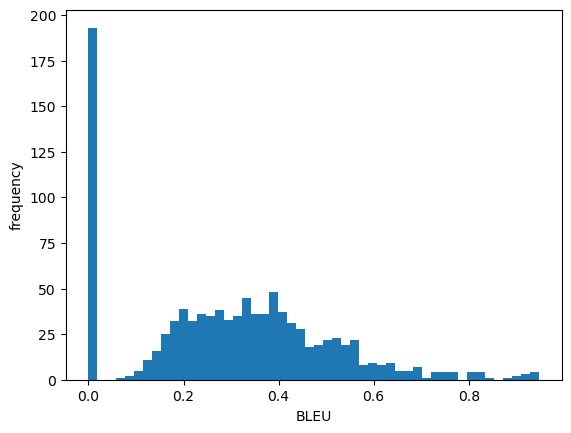

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(hist_bleus, bins=50)
plt.xlabel("BLEU")
plt.ylabel("frequency")
plt.show()

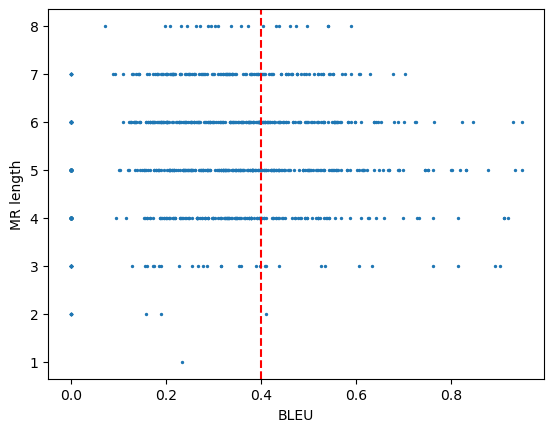

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.scatter(hist_mr_length, hist_bleus, s=2)
plt.scatter(hist_bleus, hist_mr_length, s=2)
plt.axvline(x=0.4, c='red', linestyle='dashed') # 翻訳の世界で概ね OK と言われるライン
plt.xlabel("BLEU")
plt.ylabel("MR length")
plt.show()